In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis

import knoten
import json

from ale import util

import ale
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

In [2]:
ale.config

{'spice_root': '/data/spice/',
 'cassini': '/scratch/jlaura/spice/co-s_j_e_v-spice-6-v1.0/cosp_1000/extras/mk/',
 'mdis': '/scratch/jlaura/spice/mess-e_v_h-spice-6-v1.0/messsp_1000/extras/mk',
 'mex': '/scratch/jlaura/spice/mex-e_m-spice-6-v1.0/mexsp_1000/EXTRAS/MK',
 'mro': '/home/krodriguez/',
 'kaguya': '/data/spice/SELENE/kernels/mk/',
 'dawn': '/data/spice/dawn-m_a-spice-6-v1.0/dawnsp_1000/extras/mk',
 'lro': '/scratch/jlaura/spice/lro-l-spice-6-v1.0/lrosp_1000/extras/mk/'}

In [340]:
import pvl
from collections import OrderedDict 
from itertools import chain
import re
import numpy as np
from numbers import Number
import tempfile
import csmapi
from pysis.exceptions import ProcessError
from warnings import warn

def point_info(cube_path, x, y, point_type, allow_outside=False):
    """
    Use Isis's campt to get image/ground point info from an image

    Parameters
    ----------
    cube_path : str
                path to the input cube

    x : float
        point in the x direction. Either a sample or a longitude value
        depending on the point_type flag

    y : float
        point in the y direction. Either a line or a latitude value
        depending on the point_type flag

    point_type : str
                 Options: {"image", "ground"}
                 Pass "image" if  x,y are in image space (sample, line) or
                 "ground" if in ground space (longitude, lattiude)

    Returns
    -------
    : PvlObject
      Pvl object containing campt returns
    """
    point_type = point_type.lower()

    if point_type not in {"image", "ground"}:
        raise Exception(f'{point_type} is not a valid point type, valid types are ["image", "ground"]')


    if isinstance(x, Number) and isinstance(y, Number):
        x, y = [x], [y]

    with tempfile.NamedTemporaryFile("w+") as f:
        # ISIS wants points in a file, so write to a temp file
        if point_type == "ground":
            # campt uses lat, lon for ground but sample, line for image.
            # So swap x,y for ground-to-image calls
            x,y = y,x
        elif point_type == "image":
            # convert to ISIS pixels
            x = np.add(x, .5)
            y = np.add(y, .5)

        f.write("\n".join(["{}, {}".format(xval,yval) for xval,yval in zip(x, y)]))
        f.flush()
        try:
            pvlres = isis.campt(from_=cube_path, coordlist=f.name, allowoutside=allow_outside, usecoordlist=True, coordtype=point_type)
        except ProcessError as e:
            warn(f"CAMPT call failed, image: {cube_path}\n{e.stderr}")
            return

        pvlres = pvl.loads(pvlres)
        if len(x) > 1 and len(y) > 1:
            for r in pvlres:
                # convert all pixels to PLIO pixels from ISIS
                r[1]["Sample"] -= .5
                r[1]["Line"] -= .5
        else:
            pvlres["GroundPoint"]["Sample"] -= .5
            pvlres["GroundPoint"]["Line"] -= .5

    return pvlres

import numpy as np
import holoviews as hv
from holoviews import opts, dim
from bokeh.models import HoverTool
import pandas as pd

import pyproj

def reproject(record, semi_major, semi_minor, source_proj, dest_proj, **kwargs):
    """
    Thin wrapper around PyProj's Transform() function to transform 1 or more three-dimensional
    point from one coordinate system to another. If converting between Cartesian
    body-centered body-fixed (BCBF) coordinates and Longitude/Latitude/Altitude coordinates,
    the values input for semi-major and semi-minor axes determine whether latitudes are
    planetographic or planetocentric and determine the shape of the datum for altitudes.
    If semi_major == semi_minor, then latitudes are interpreted/created as planetocentric
    and altitudes are interpreted/created as referenced to a spherical datum.
    If semi_major != semi_minor, then latitudes are interpreted/created as planetographic
    and altitudes are interpreted/created as referenced to an ellipsoidal datum.

    Parameters
    ----------
    record : object
          Pandas series object

    semi_major : float
              Radius from the center of the body to the equater

    semi_minor : float
              Radius from the pole to the center of mass

    source_proj : str
                      Pyproj string that defines a projection space ie. 'geocent'

    dest_proj : str
                   Pyproj string that defines a project space ie. 'latlon'

    Returns
    -------
    : list
    Transformed coordinates as y, x, z

    """
    source_pyproj = pyproj.Proj(proj = source_proj, a = semi_major, b = semi_minor)
    dest_pyproj = pyproj.Proj(proj = dest_proj, a = semi_major, b = semi_minor)

    y, x, z = pyproj.transform(source_pyproj, dest_pyproj, record[0], record[1], record[2], **kwargs)

    return y, x, z


import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

def compare_to_isis(isd, cube, nx=10, ny=50, width=500, height=500):
    """
    """    
    
    def plot_diff(data, colx='x', coly='y', coldx='diffx', coldy='diffy', colmag='magnitude', size=1000):
        import matplotlib.cm as cm
        from matplotlib.colors import Normalize
        
        fig = make_subplots(rows=2, cols=2, column_widths=[0.2, 0.8])
        
        arrow_scale = (data[coly].iloc[1]-data[colx].iloc[0]+data[colx].iloc[1]-data[colx].iloc[0])/10
#         fig.add_trace(ff.create_quiver(data[colx],
#                                data[coly],
#                                data[coldx],
#                                data[coldy],
#                                scale=arrow_scale, 
#                                name='csm error direction').data[1], row=1,col=1)
        
    
        text = [f'{coldx}: {r[coldx]}<br>{coldy}: {r[coldy]}<br>{colmag}: {r[colmag]}' for i,r in data.iterrows()]
        fig.add_trace(go.Scatter(x=data[colx], y=data[coly], 
                    customdata=data, 
                    mode='markers',
                    name='ISIS Points',
                    hovertext=text,
                    marker=dict(
                            size=5,
                            color=data[colmag],
                            colorbar=dict(
                                thickness = 5,
                                outlinewidth = 0,
                                ypad=0
                            ),
                            colorscale="RdYlBu"
                    )), row=1, col=1)
        
        text = [f'{coldx}: {r[coldx]}<br>{coldy}: {r[coldy]}<br>{colmag}: {r[colmag]}' for i,r in data.iterrows()]
        fig.add_trace(go.Scatter(x=data[colx], y=data[coly], 
                    customdata=data, 
                    mode='markers',
                    name='ISIS Points',
                    hovertext=text,
                    marker=dict(
                            size=5,
                            color=data[colmag],
                            colorbar=dict(
                                thickness = 5,
                                outlinewidth = 0,
                                ypad=0
                            ),
                            colorscale="RdYlBu"
                    )), row=1, col=1)
        
        
        fig.update_layout(width=width, height=height, legend=dict(x=0, y=-1))
        fig.update_yaxes(autorange="reversed", title_text=coly)
        fig.update_xaxes(title_text=colx)
        
        return fig
    
    isdjson = json.load(open(isd))
    
    nlines = isdjson['image_lines']
    nsamples = isdjson['image_samples']
    
    # generate meshgrid
    xs, ys = np.mgrid[0:nsamples:nsamples/nx, 0:nlines:nlines/ny]
    xs, ys = xs.flatten(), ys.flatten()
    
    csmcam = knoten.csm.create_csm(isd)
    
    # get data
    ##########################
    isis_pts = point_info(cube, xs, ys, 'image')
    isisgnds = np.asarray([np.asarray(g[1]['BodyFixedCoordinate'].value)*1000 for g in isis_pts]) 
    csm_pts = np.asarray([[p.samp, p.line] for p in [csmcam.groundToImage(csmapi.EcefCoord(*bf)) for bf in isisgnds]])
    isis2csm_diff = csm_pts - np.asarray([xs,ys]).T
    isis2csm_diffmag = np.linalg.norm(isis2csm_diff, axis=1)
    isis2csm_angles = np.arctan2(*isis2csm_diff.T[::-1])

    data = np.asarray([csm_pts.T[0], csm_pts.T[1], xs, ys,  isis2csm_diff.T[0], isis2csm_diff.T[1], isis2csm_diffmag, isis2csm_angles]).T
    data = pd.DataFrame(data, columns=['csm sample', 'csm line', 'isis sample','isis line', 'diff sample', 'diff line', 'magnitude', 'angles'])
    
    plot = plot_diff(data, colx='isis sample', coly='isis line', coldx='diff sample', coldy='diff line')
    return plot
    
    
    
    # CS101 C++ programming class style dividers
    ##############################

    isis2ground2csm_plot = hv.VectorField((data['x'], data['y'], data['angles'], data['magnitude']), group='isis2ground2csmimage' ).opts(opts.VectorField(pivot='tail', colorbar=True, cmap='coolwarm', title='ISIS2Ground->CSM2Image Pixel Diff', arrow_heads=True, magnitude='Magnitude', color=dim('Magnitude')))
    isis2ground2csm_plot = isis2ground2csm_plot.redim(x='sample', y='line')
    isis2ground2csm_plot = isis2ground2csm_plot.opts(plot=dict(width=width, height=height))
    isis2ground2csm_plot = isis2ground2csm_plot*hv.Points(data, group='isis2ground2csmimage').opts(size=5, color='magnitude', cmap='coolwarm',tools=['hover'], invert_yaxis=True)
    isis2ground2csm_plot = isis2ground2csm_plot.redim.range(a=(data['magnitude'].min(), data['magnitude'].max()))
    ##############################
    
    
    
    
    ##############################
    csmgnds = np.asarray([[p.x, p.y, p.z] for p in [csmcam.imageToGround(csmapi.ImageCoord(y,x), 0) for x,y in zip(xs,ys)]])
    csmlon, csmlat, _ = reproject(csmgnds.T, isdjson['radii']['semimajor'], isdjson['radii']['semiminor'], 'geocent', 'latlong')
    isis_imgpts = point_info(cube, csmlon, csmlat, 'ground')
    isis_imgpts = np.asarray([(p[1]['Sample'], p[1]['Line']) for p in isis_imgpts])

    csm2isis_diff = isis_imgpts - np.asarray([xs,ys]).T
    csm2isis_diffmag = np.linalg.norm(csm2isis_diff, axis=1)
    csm2isis_angles = np.arctan2(*(csm2isis_diff/csm2isis_diffmag[:,np.newaxis]).T[::-1])
    
    csm2isis_data = np.asarray([xs, ys, isis_imgpts.T[0], isis_imgpts.T[1], csm2isis_diff.T[0], csm2isis_diff.T[1], csm2isis_diffmag, csm2isis_angles]).T
    csm2isis_data = pd.DataFrame(csm2isis_data, columns=['x', 'y', 'csmx','csmy', 'diffx', 'diffy', 'magnitude', 'angles'])
    
    csm2ground2isis_plot = hv.VectorField((csm2isis_data['x'], csm2isis_data['y'], csm2isis_data['angles'], csm2isis_data['magnitude']),  group='csmground2image2isis').opts(opts.VectorField(pivot='tail', colorbar=True, cmap='coolwarm', title='CSM2Ground->ISIS2Image Pixel Diff', arrow_heads=True, magnitude='Magnitude', color=dim('Magnitude')))
    csm2ground2isis_plot = csm2ground2isis_plot.redim(x='sample', y='line')
    csm2ground2isis_plot = csm2ground2isis_plot.opts(plot=dict(width=width, height=height))
    csm2ground2isis_plot = csm2ground2isis_plot*hv.Points(csm2isis_data, group='csmground2image2isis').opts(size=5, color='magnitude', cmap='coolwarm', tools=['hover'], invert_yaxis=True)
    ###############################
    
    ###############################
    isis_lonlat = np.asarray([[p[1]['PositiveEast360Longitude'].value, p[1]['PlanetocentricLatitude'].value] for p in isis_pts])
    csm_lonlat = np.asarray([csmlon+360, csmlat]).T
    
    isiscsm_difflatlon = isis_lonlat - csm_lonlat
    isiscsm_difflatlonmag = np.linalg.norm(isiscsm_difflatlon, axis=1)
    isiscsm_angleslatlon = np.arctan2(*isiscsm_difflatlon.T[::-1])
    
    isiscsm_latlondata = np.asarray([isis_lonlat.T[0], isis_lonlat.T[1], csm_lonlat.T[0], csm_lonlat.T[1], isiscsm_difflatlon.T[0], isiscsm_difflatlon.T[1], isiscsm_difflatlonmag, isiscsm_angleslatlon]).T
    isiscsm_latlondata = pd.DataFrame(isiscsm_latlondata, columns=['isislon', 'isislat', 'csmlon','csmlat', 'difflon', 'difflat', 'magnitude', 'angles'])
    
    isiscsm_plotlatlon = hv.VectorField((isiscsm_latlondata['isislon'], isiscsm_latlondata['isislat'], isiscsm_latlondata['angles'], isiscsm_latlondata['magnitude']), group='isisvscsmlatlon').opts(opts.VectorField(pivot='tail', colorbar=True, cmap='coolwarm', title='Image2Ground latlon Diff', arrow_heads=True, magnitude='Magnitude', color=dim('Magnitude')))
    isiscsm_plotlatlon = isiscsm_plotlatlon.redim(x='longitude', y='latitude')
    isiscsm_plotlatlon = isiscsm_plotlatlon.opts(plot=dict(width=width, height=height))
    isiscsm_plotlatlon = isiscsm_plotlatlon*hv.Points(isiscsm_latlondata, ['isislon', 'isislat'], group='isisvscsmlatlon').opts(size=5, color='magnitude', cmap='coolwarm', tools=['hover'], invert_yaxis=True)
    ###############################
    
    ###############################
    isiscsm_diffbf = isisgnds - csmgnds
    isiscsm_diffbfmag = np.linalg.norm(isiscsm_diffbf, axis=1)
    isiscsm_anglesbf = np.arctan2(*isiscsm_diffbf.T[::-1])
    
    isiscsm_bfdata = np.asarray([isisgnds.T[0], isisgnds.T[1], isisgnds.T[2], csmgnds.T[0], csmgnds.T[1], csmgnds.T[2], isiscsm_diffbf.T[0], isiscsm_diffbf.T[1], isiscsm_diffbf.T[2], isiscsm_diffbfmag, isiscsm_anglesbf]).T
    isiscsm_bfdata = pd.DataFrame(isiscsm_bfdata, columns=['isisx', 'isisy', 'isisz', 'csmx','csmy', 'csmz', 'diffx', 'diffy', 'diffz', 'magnitude', 'angles'])
    
    isiscsm_plotbf = (hv.Points(isiscsm_bfdata, ['isisx', 'isisy'], label='ISIS')*hv.Points(isiscsm_bfdata, ['csmx', 'csmy'], label='CSM')).opts(opts.Points(alpha=.5))+\
                     (hv.Points(isiscsm_bfdata, ['isisx', 'isisz'], label='ISIS')*hv.Points(isiscsm_bfdata, ['csmx', 'csmz'], label='CSM')).opts(opts.Points(alpha=.5))+\
                     (hv.Points(isiscsm_bfdata, ['isisy', 'isisz'], label='ISIS')*hv.Points(isiscsm_bfdata, ['csmy', 'csmz'], label='CSM')).opts(opts.Points(alpha=.5))
    isiscsm_plotbf = isiscsm_plotbf.opts(plot=dict(width=width, height=height))          
    
    return isis2ground2csm_plot, csm2ground2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata
    


In [286]:
ff.create_quiver?

In [148]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

# !wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]
camera = knoten.csm.create_csm(fileName)

In [6]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

# try: 
#     isis.mroctx2isis(from_=fileName, to=cub_loc)
# except ProcessError as e:
#     print(e.stderr)

# try:
#     results = isis.spiceinit(from_=cub_loc, shape='ellipsoid')
# except ProcessError as e:
#     print(e.stderr)

# try:
#     results = isis.footprintinit(from_=cub_loc)
# except ProcessError as e:
#     print(e.stderr)
    
util.write_metakernel_from_cube(cub_loc, '/home/krodriguez/mro_2018_v05.tm')

with MroCtxPds3LabelNaifSpiceDriver(fileName) as driver:
    usgscsmString = to_usgscsm(driver)
    usgscsm_dict = json.loads(usgscsmString)
    
    csm_isd = os.path.splitext(fileName)[0] + '.json'
    json.dump(usgscsm_dict, open(csm_isd, 'w'))

In [341]:
# plot1, plot2, plot3, plot4, df1, df2, df3, df4= compare_to_isis(csm_isd, cub_loc, 10, 20, 500,500)
# (plot1 + plot2 + plot3).cols(2)
compare_to_isis(csm_isd, cub_loc, 5, 10, 500,1000)

IndexError: tuple index out of range

In [263]:
f'test\ntest2'.encode()

b'test\ntest2'

In [121]:
plot4

:Layout
   .Overlay.I   :Overlay
      .Points.ISIS :Points   [isisx,isisy]   (isisz,csmx,csmy,csmz,diffx,diffy,diffz,magnitude,angles)
      .Points.CSM  :Points   [csmx,csmy]   (isisx,isisy,isisz,csmz,diffx,diffy,diffz,magnitude,angles)
   .Overlay.II  :Overlay
      .Points.ISIS :Points   [isisx,isisz]   (isisy,csmx,csmy,csmz,diffx,diffy,diffz,magnitude,angles)
      .Points.CSM  :Points   [csmx,csmz]   (isisx,isisy,isisz,csmy,diffx,diffy,diffz,magnitude,angles)
   .Overlay.III :Overlay
      .Points.ISIS :Points   [isisy,isisz]   (isisx,csmx,csmy,csmz,diffx,diffy,diffz,magnitude,angles)
      .Points.CSM  :Points   [csmy,csmz]   (isisx,isisy,isisz,csmx,diffx,diffy,diffz,magnitude,angles)

In [85]:
df1.describe()

,x,y,isisx,isisy,diffx,diffy,magnitude,angles
count,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2275.701228,2.165766e+04,2275.200000,21657.600000,0.501228,0.063828,0.507819,0.126196
std,1459.540991,1.389336e+04,1459.541481,13893.356878,0.018046,0.050887,0.017687,0.100806
min,0.483079,-8.427498e-08,0.000000,0.000000,0.478591,-0.022740,0.492349,-0.044516
25%,1011.699217,9.625700e+03,1011.200000,9625.600000,0.489702,0.032162,0.500013,0.064173
50%,2275.713769,2.165761e+04,2275.200000,21657.600000,0.499505,0.066733,0.501894,0.133932
75%,3539.699383,3.368970e+04,3539.200000,33689.600000,0.500640,0.100172,0.508839,0.191541
max,4550.949426,4.331523e+04,4550.400000,43315.200000,0.553845,0.151048,0.563224,0.299736


In [86]:
df2.describe()

,x,y,csmx,csmy,diffx,diffy,magnitude,angles
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2275.200000,21657.600000,2253.903853,25794.499811,-21.296147,4136.899811,4142.447536,-1.577810
std,1459.541481,13893.356878,1441.547458,13078.414393,293.187446,12613.927440,12615.513741,1.055034
min,0.000000,0.000000,-0.862463,4810.417403,-506.378272,-2.382597,2.084876,-1.952883
25%,1011.200000,9625.600000,1010.415799,14436.180517,-0.811746,-2.219483,2.218219,-1.939006
50%,2275.200000,21657.600000,2260.566072,24062.718275,-0.796405,-2.109938,2.288933,-1.927041
75%,3539.200000,33689.600000,3538.402294,38500.382949,-0.778264,-2.016369,2.450392,-1.913151
max,4550.400000,43315.200000,4549.624829,43313.264847,2499.500000,43313.263958,43316.223867,1.582487


In [87]:
df3.head()

,isislon,isislat,csmlon,csmlat,difflon,difflat,magnitude,angles
0,196.600908,-22.104379,196.600863,-22.104619,0.000045,0.000240,0.000244,1.385721
1,196.538900,-21.618813,196.538858,-21.619061,0.000042,0.000248,0.000252,1.404385
2,196.477090,-21.133234,196.477042,-21.133474,0.000048,0.000241,0.000245,1.374193
3,196.416060,-20.647603,196.416017,-20.647835,0.000043,0.000232,0.000236,1.387989
4,196.354913,-20.162057,196.354869,-20.162283,0.000044,0.000226,0.000230,1.378590


In [88]:
df4.describe()

,isisx,isisy,isisz,csmx,csmy,csmz,diffx,diffy,diffz,magnitude,angles
count,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-3.058451e+06,-907674.231310,-1.154657e+06,-3.058452e+06,-907671.780596,-1.154658e+06,2.907056,-2.450713,0.588594,2.583169,2.907056
std,3.024726e+04,7328.259809,7.793340e+04,3.024727e+04,7328.248024,7.793340e+04,0.094992,0.092220,0.240730,0.092037,0.094992
min,-3.106976e+06,-920533.067339,-1.276896e+06,-3.106977e+06,-920530.645257,-1.276897e+06,2.744779,-2.705231,0.178476,2.449146,2.744779
25%,-3.084665e+06,-913839.269441,-1.222168e+06,-3.084665e+06,-913836.798340,-1.222169e+06,2.842802,-2.470462,0.444328,2.532589,2.842802
50%,-3.059320e+06,-907735.641114,-1.154979e+06,-3.059320e+06,-907733.055864,-1.154980e+06,2.897969,-2.444349,0.597131,2.563157,2.897969
75%,-3.032706e+06,-901448.859999,-1.087323e+06,-3.032707e+06,-901446.363670,-1.087324e+06,2.963432,-2.391555,0.778176,2.592324,2.963432
max,-3.007230e+06,-893830.640339,-1.031379e+06,-3.007231e+06,-893828.238935,-1.031379e+06,3.068874,-2.284435,0.968947,2.857959,3.068874


In [124]:
import plotly
plotly.__version__

'4.0.0'

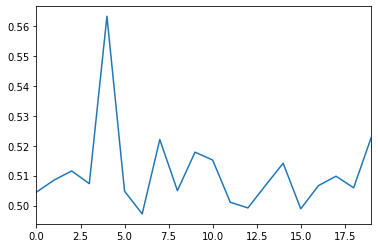

In [323]:
df1[df1.isisx==0]['magnitude'].plot()

In [134]:
ff.create_quiver?